
# Performance Evaluation of CVaR-VQE 


ridefinire time to solution
in lidar loro trovano l'ottimo per ogni N numero di istanze parallele
carleo non-stoquastic QA con troyer

Noi geralizziamo facendo una funzione in 2D oppure numero di shots come parametro t in modo fa fare una famiglia di funzioni

Cosa vogliamo: resolurce to solution, moltiplico N_shot e N_step
ferromagnetico bias
mi servono alcuni for
- random su theta
- scalo su shots 
- scalo su step (maxiter)

alpha suggerito da loro (0.25)

valuto con RTS (TTS dove moltiplico per gli shots) non normalizzato per n_max

n.b. green quantum computing paper montangero


## Plot for $p=1$ 


In [ ]:
import numpy as np
from scipy.optimize import curve_fit
from math import ceil
from json import JSONEncoder
from matplotlib import pyplot as plt
from src.utils import collect_results, NumpyArrayEncoder

In [118]:
qubits = np.arange(4, 22, 2, dtype=int)
circ_depth = 1

psucc, ts, shots, nfevs = collect_results(qubits, circ_depth)

directory: results/N4/p1/
directory: results/N6/p1/
directory: results/N8/p1/
directory: results/N10/p1/
directory: results/N12/p1/
directory: results/N14/p1/
directory: results/N16/p1/
directory: results/N18/p1/
directory: results/N20/p1/


No zeros in succes probability for N=4
No zeros in succes probability for N=6
No zeros in succes probability for N=8
No zeros in succes probability for N=10
No zeros in succes probability for N=12
No zeros in succes probability for N=14
N=16, t=8, shots=2, nfev=4
N=18, t=64, shots=8, nfev=24
N=20, t=1024, shots=512, nfev=30


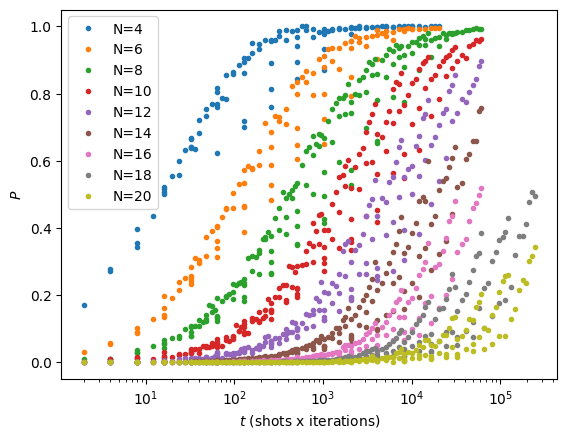

In [119]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    plt.plot(p_t[0], p_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()

In [120]:
def running_mean(x, n):
    cumsum = np.cumsum(np.pad(x, int(ceil(n/2)), mode='reflect')) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

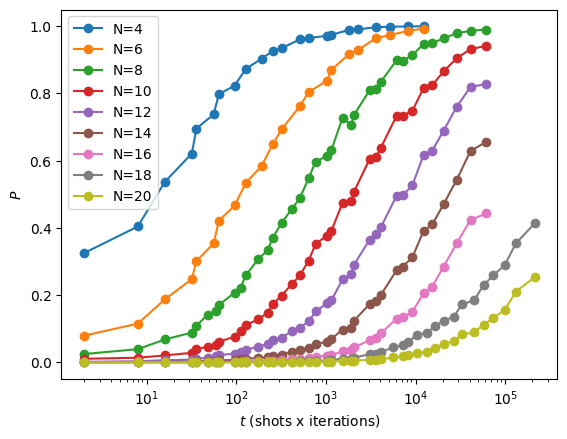

In [121]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    len_window = 12
    #p_t[1] = np.convolve(p_t[1], np.ones(len_window) / len_window, mode='same')
    p_t[1] = running_mean(p_t[1], len_window)
    plt.plot(p_t[0][::5], p_t[1][::5], "o-", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

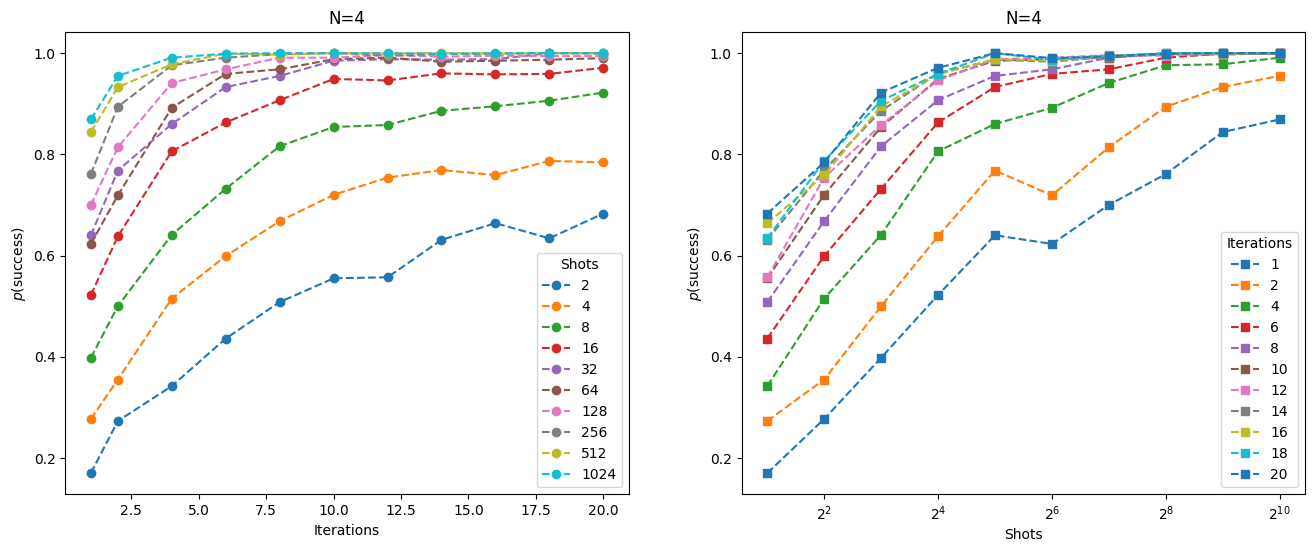

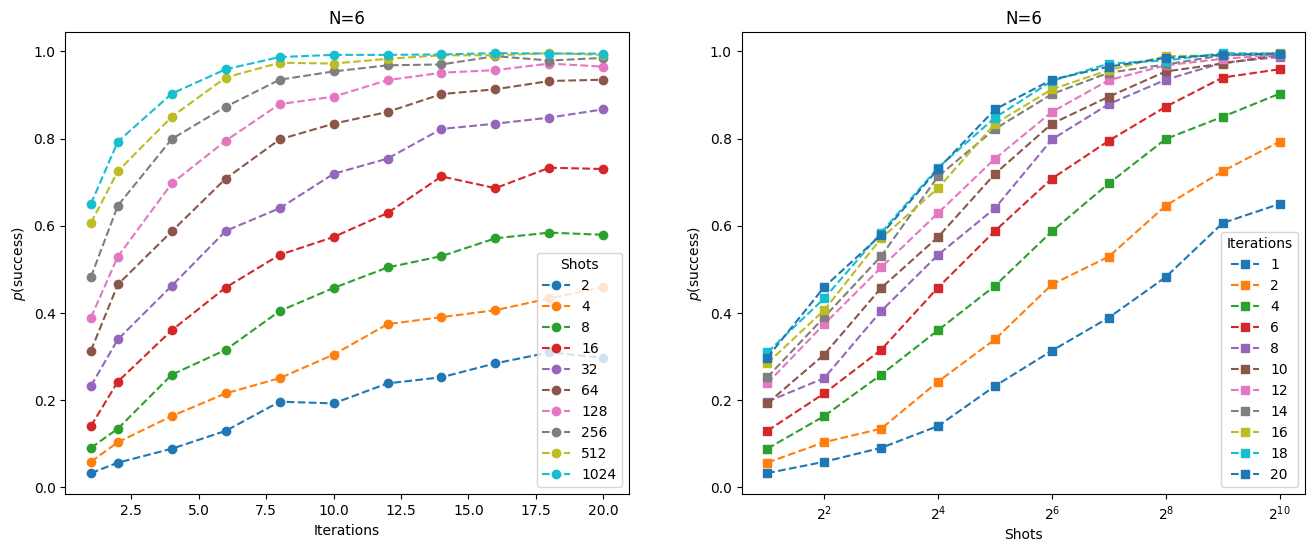

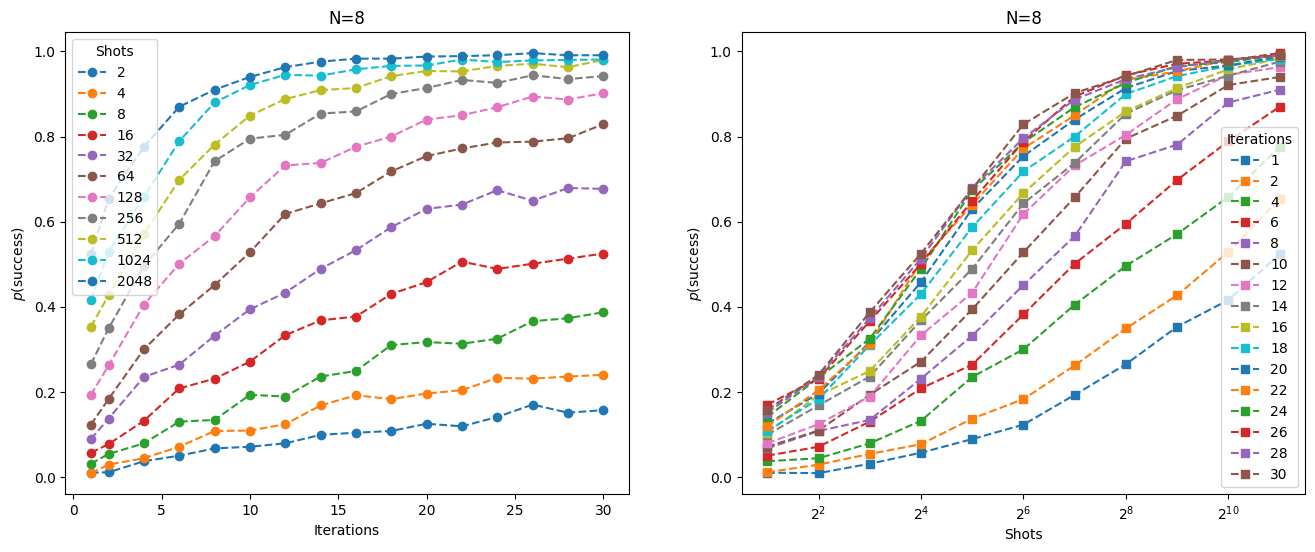

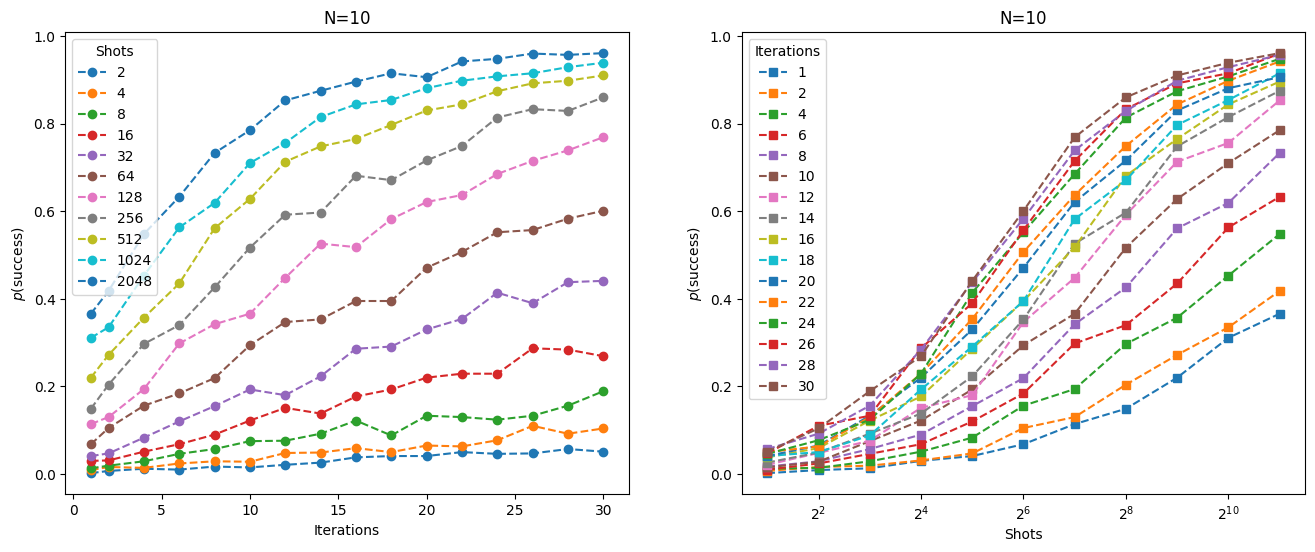

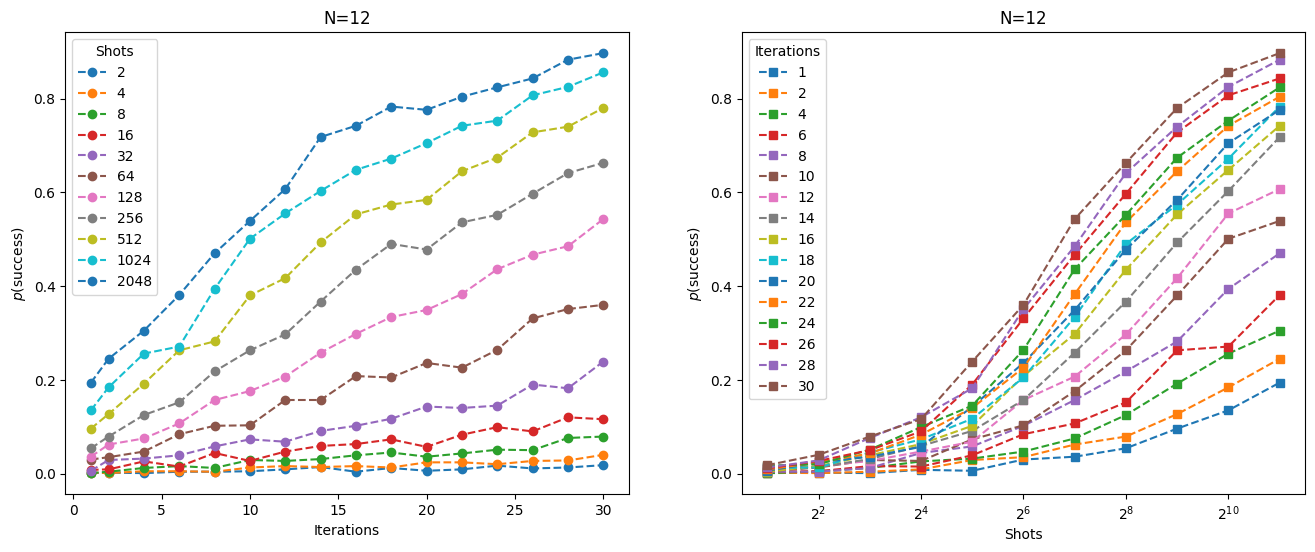

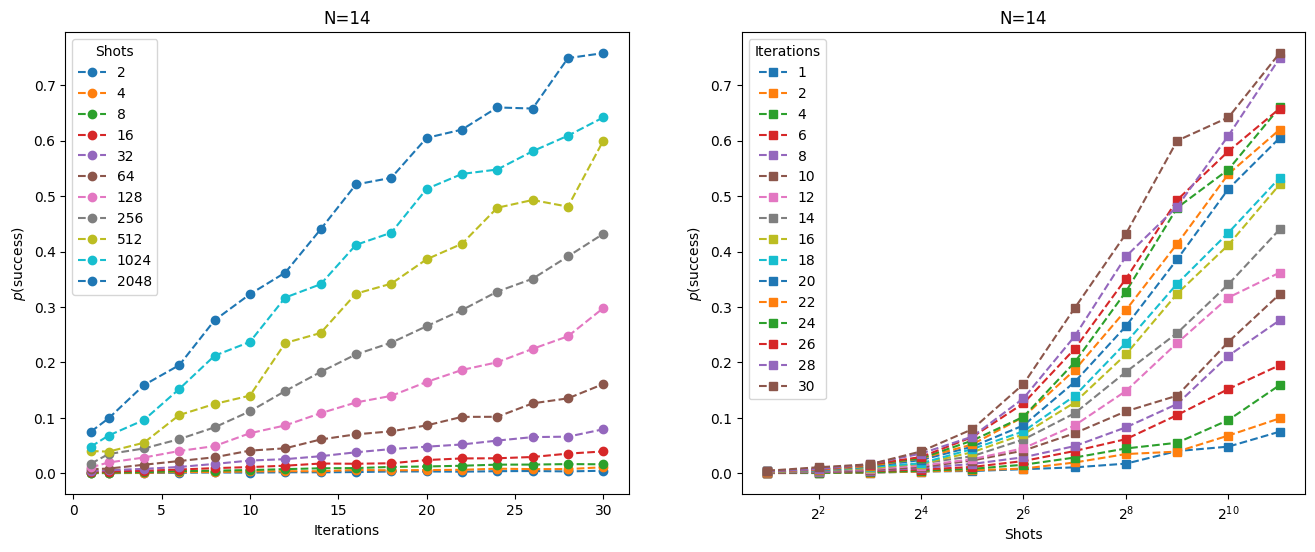

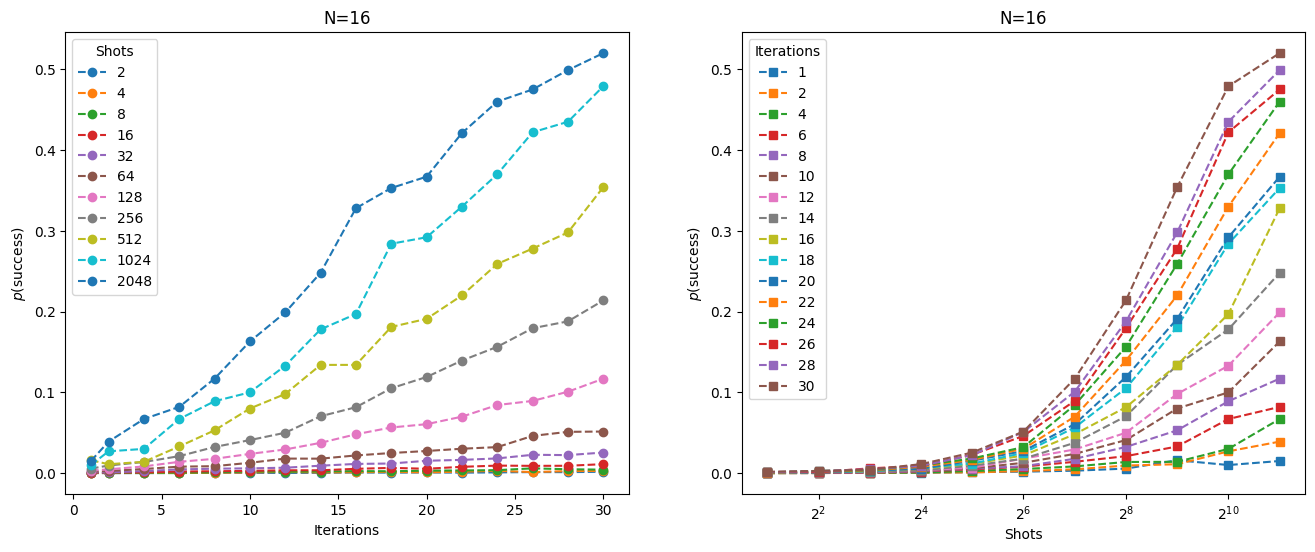

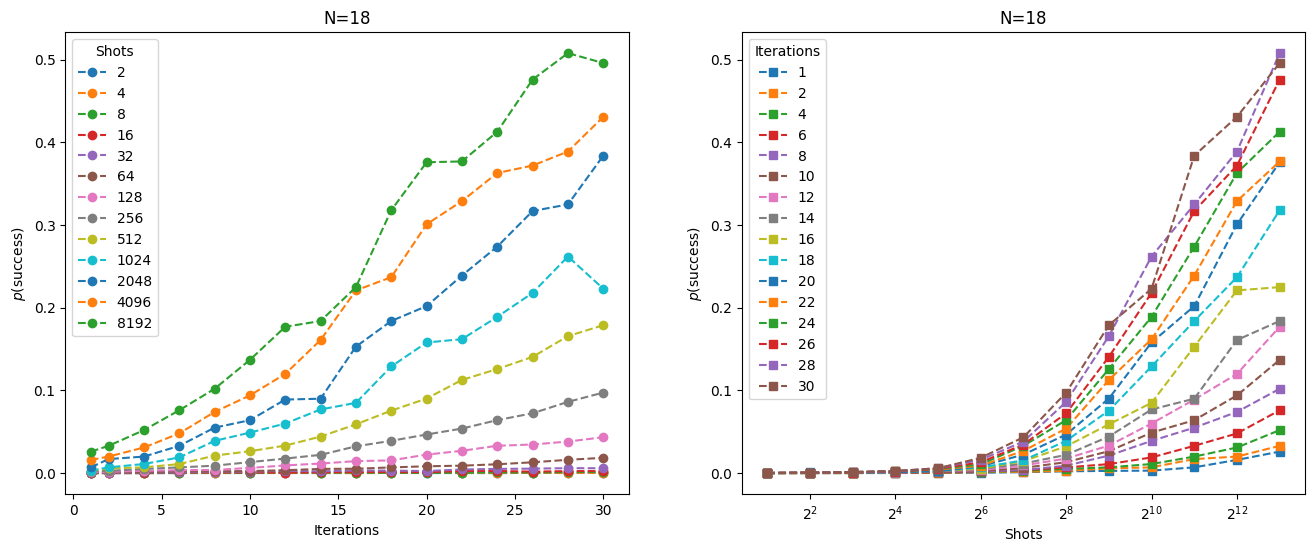

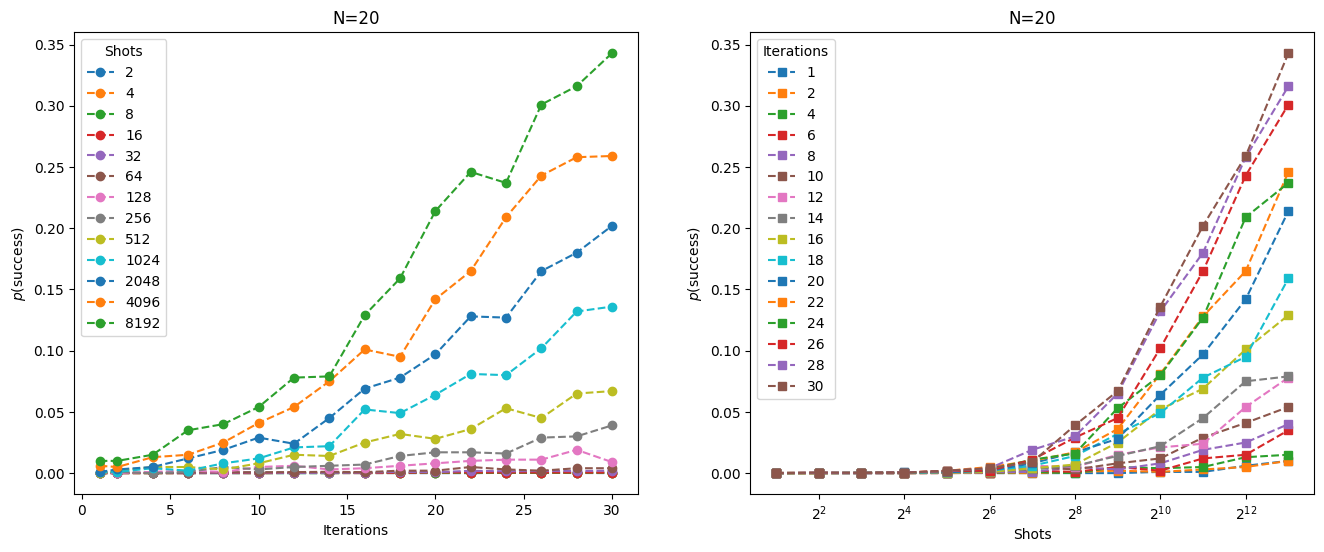

In [127]:
for k, (p,s,nfev) in enumerate(zip(psucc, shots, nfevs)):
    len_iter = np.max(nfev)//2+1
    p = np.reshape(p, (-1,len_iter))
    s = np.reshape(s, (-1,len_iter))
    nfev = np.reshape(nfev, (-1,len_iter))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    for i in range(p.shape[0]):
        ax1.plot(nfev[i,:], p[i,:], '--o', label=s[i,0])
    for j in range(p.shape[1]):
        ax2.plot(s[:,j], p[:,j], '--s', label=nfev[0,j])

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(r'$p$(success)')
    #ax1.set_ylim(0,1.1)

    ax2.set_xlabel('Shots')
    ax2.set_xscale('log', base=2)
    ax2.set_ylabel(r'$p$(success)')
    #ax2.set_ylim(0,1.1)

    ax1.legend(title='Shots')
    ax2.legend(title='Iterations')

    ax1.set_title(f'N={4+k*2}')
    ax2.set_title(f'N={4+k*2}')

In [123]:
def compute_r(p, p_d=0.99):
    rt = np.log(1-p_d)
    rt /= np.log(1-p)
    return rt

tts_list = []
for p,t in zip(psucc, ts):
    p = np.asarray(p)
    t = np.asarray(t)
    #print(p[:20],t.shape)
    mask =  p == 0.
    mask += p == 1. # mask += p == 1.
    #p[mask] = 0.00005
    p = np.delete(p, mask)
    t = np.delete(t, mask)

    rt = compute_r(p)
    tts_list.append(t*rt)

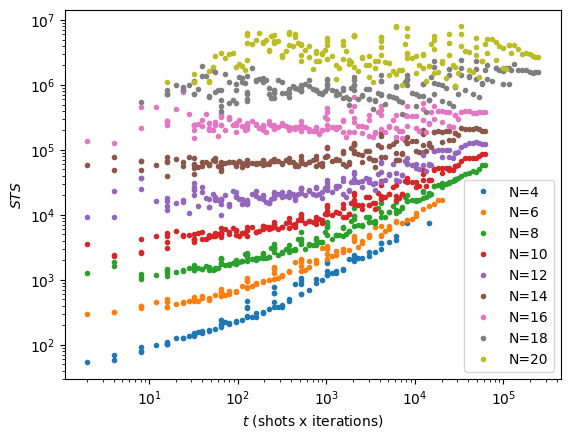

In [124]:
for i, (tts,t) in enumerate(zip(tts_list, ts)):
    if 4+i*2 > 18:
        pass#continue
    t = np.asarray(t)
    mask = np.asarray(psucc[i]) == 0.
    mask += np.asarray(psucc[i]) == 1. # mask += np.asarray(psucc[i]) == 1.
    t = np.delete(t, mask)

    tts_t = np.vstack((t, tts))
    tts_t = tts_t[:, np.argsort(tts_t[0, :])]
    # roll-mean
    len_window = 2
    tts_t[1] = running_mean(tts_t[1], len_window)
    plt.plot(tts_t[0], tts_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1.5,50000)
    #plt.ylim(10000, 500000)
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$STS$")
    plt.legend()
    plt.savefig("STS-t_roll8.png")

In [125]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

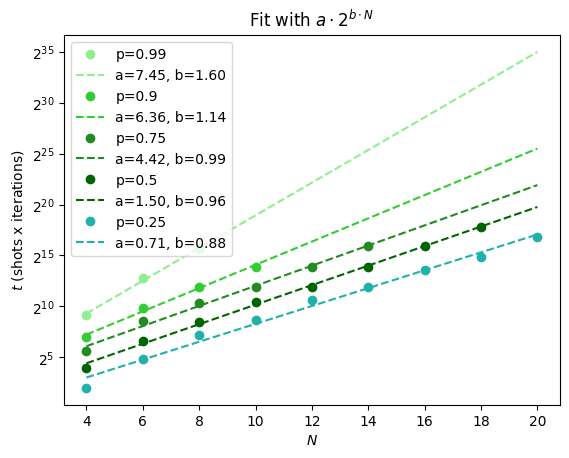

In [126]:
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
min_psucc_lst = [0.99, 0.9, 0.75, 0.5, 0.25]
min_qubits = 4 
max_qubits = 20 
for min_psucc, color in zip(min_psucc_lst, colors):
    step_size = []
    for i, pt in enumerate(pt_all):
        mask = pt[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size.append(pt[0][mask][0])

    x_axes = 4 + 2*np.arange(len(step_size))

    popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
    plt.plot(x_axes, step_size, "o", label=f"p={min_psucc}", color=color)
    plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "--", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")

plt.legend(loc="best")
plt.title(r"Fit with $a \cdot 2^{b \cdot N}$")

plt.savefig("t_succ.png")

## Plot for $p=2$

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from math import ceil
from json import JSONEncoder
from matplotlib import pyplot as plt
from src.utils import collect_results, NumpyArrayEncoder

In [3]:
qubits = np.arange(4, 22, 2, dtype=int)
circ_depth = 2

psucc, ts, shots, nfevs = collect_results(qubits, circ_depth)

directory: results/N4/p2/
directory: results/N6/p2/
directory: results/N8/p2/
directory: results/N10/p2/
directory: results/N12/p2/
directory: results/N14/p2/
directory: results/N16/p2/
directory: results/N18/p2/
directory: results/N20/p2/


No zeros in succes probability for N=4
No zeros in succes probability for N=6
No zeros in succes probability for N=8
No zeros in succes probability for N=10
No zeros in succes probability for N=12
No zeros in succes probability for N=14
N=16, t=12, shots=4, nfev=6
N=18, t=32, shots=16, nfev=16
N=20, t=1792, shots=1024, nfev=30


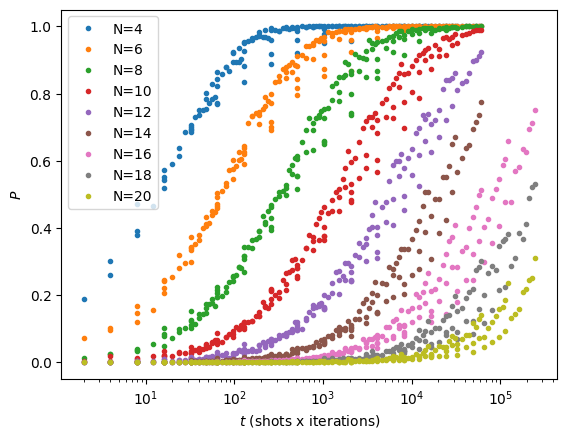

In [4]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    plt.plot(p_t[0], p_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    #plt.savefig("p_t_n4-18.png")

In [5]:
def running_mean(x, n):
    cumsum = np.cumsum(np.pad(x, int(ceil(n/2)), mode='reflect')) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

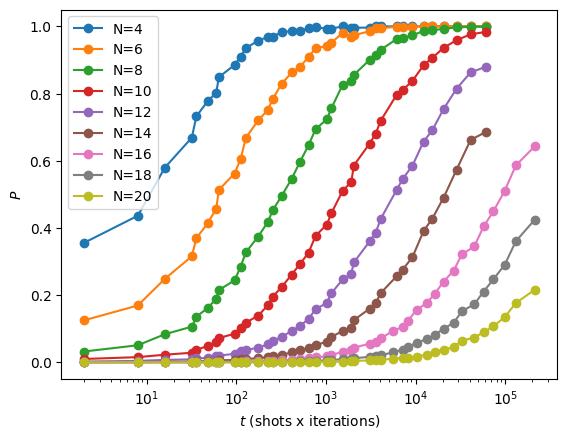

In [6]:
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    len_window = 12
    #p_t[1] = np.convolve(p_t[1], np.ones(len_window) / len_window, mode='same')
    p_t[1] = running_mean(p_t[1], len_window)
    plt.plot(p_t[0][::5], p_t[1][::5], "o-", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$P$")
    plt.legend()
    plt.savefig("p_t_n4-18.png")

In [ ]:
for k, (p,s,nfev) in enumerate(zip(psucc, shots, nfevs)):
    len_iter = np.max(nfev)//2+1

    p = np.reshape(p, (-1,len_iter))
    s = np.reshape(s, (-1,len_iter))
    nfev = np.reshape(nfev, (-1,len_iter))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
    for i in range(p.shape[0]):
        ax1.plot(nfev[i,:], p[i,:], '--o', label=s[i,0])
    for j in range(p.shape[1]):
        ax2.plot(s[:,j], p[:,j], '--s', label=nfev[0,j])

    ax1.set_xlabel('Iterations')
    ax1.set_ylabel(r'$p$(success)')
    #ax1.set_ylim(0,1.1)

    ax2.set_xlabel('Shots')
    ax2.set_xscale('log', base=2)
    ax2.set_ylabel(r'$p$(success)')
    #ax2.set_ylim(0,1.1)

    ax1.legend(title='Shots')
    ax2.legend(title='Iterations')

    ax1.set_title(f'N={4+k*2}')
    ax2.set_title(f'N={4+k*2}')

    #plt.savefig(f'shots_iter_N{4+k*2}.png')

In [7]:
def compute_r(p, p_d=0.99):
    rt = np.log(1-p_d)
    rt /= np.log(1-p)
    return rt

tts_list = []
for p,t in zip(psucc, ts):
    p = np.asarray(p)
    t = np.asarray(t)
    #print(p[:20],t.shape)
    mask =  p == 0.
    mask += p == 1. # mask += p == 1.
    #p[mask] = 0.00005
    p = np.delete(p, mask)
    t = np.delete(t, mask)

    rt = compute_r(p)
    tts_list.append(t*rt)

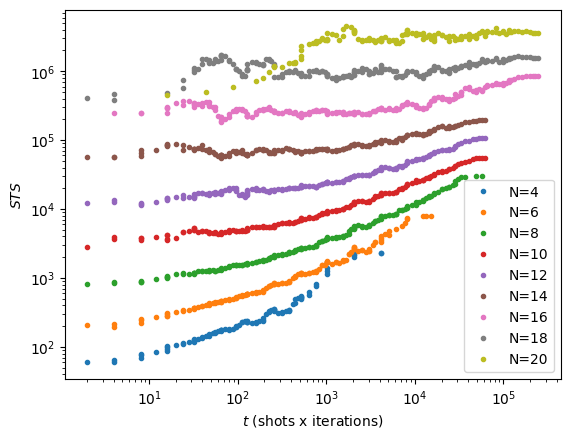

In [8]:
for i, (tts,t) in enumerate(zip(tts_list, ts)):
    if 4+i*2 > 18:
        pass#continue
    t = np.asarray(t)
    mask = np.asarray(psucc[i]) == 0.
    mask += np.asarray(psucc[i]) == 1. # mask += np.asarray(psucc[i]) == 1.
    t = np.delete(t, mask)

    tts_t = np.vstack((t, tts))
    tts_t = tts_t[:, np.argsort(tts_t[0, :])]
    # roll-mean
    len_window = 8
    tts_t[1] = running_mean(tts_t[1], len_window)
    plt.plot(tts_t[0], tts_t[1], ".", label=f"N={4+i*2}")

    plt.xscale('log')
    plt.yscale('log')
    #plt.xlim(1.5,50000)
    #plt.ylim(10000, 500000)
    plt.xlabel(r"$t$ (shots x iterations)")
    plt.ylabel(r"$STS$")
    plt.legend()
    plt.savefig("STS-t_roll8.png")

In [9]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

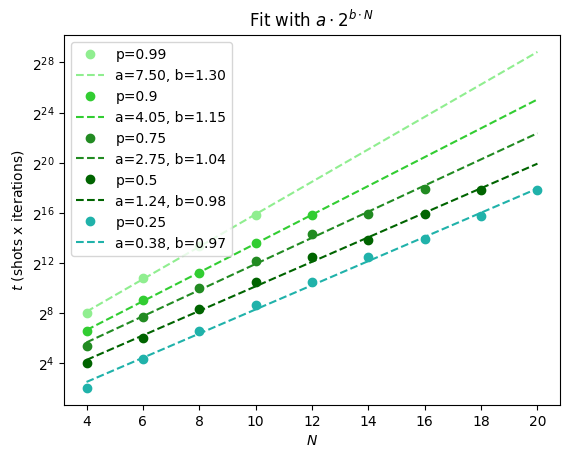

In [10]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x
    
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
min_psucc_lst = [0.99, 0.9, 0.75, 0.5, 0.25]
min_qubits = 4 
max_qubits = 20 
for min_psucc, color in zip(min_psucc_lst, colors):
    step_size = []
    for i, pt in enumerate(pt_all):
        mask = pt[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size.append(pt[0][mask][0])

    x_axes = 4 + 2*np.arange(len(step_size))

    popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
    plt.plot(x_axes, step_size, "o", label=f"p={min_psucc}", color=color)
    plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "--", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")

plt.legend(loc="best")
plt.title(r"Fit with $a \cdot 2^{b \cdot N}$")

plt.savefig("t_succ.png")


## Simulation with $p=1,2$



In [128]:
qubits = np.arange(4, 22, 2, dtype=int)

psucc_1, ts_1, shots_1, nfevs_1 = collect_results(qubits, 1)
psucc_2, ts_2, shots_2, nfevs_2 = collect_results(qubits, 2)

directory: results/N4/p1/
directory: results/N6/p1/
directory: results/N8/p1/
directory: results/N10/p1/
directory: results/N12/p1/
directory: results/N14/p1/
directory: results/N16/p1/
directory: results/N18/p1/
directory: results/N20/p1/
directory: results/N4/p2/
directory: results/N6/p2/
directory: results/N8/p2/
directory: results/N10/p2/
directory: results/N12/p2/
directory: results/N14/p2/
directory: results/N16/p2/
directory: results/N18/p2/
directory: results/N20/p2/


No zeros in success probability for N=4
No zeros in succes probability for N=4
No zeros in success probability for N=6
No zeros in succes probability for N=6
No zeros in success probability for N=8
No zeros in succes probability for N=8
No zeros in success probability for N=10
No zeros in succes probability for N=10
No zeros in success probability for N=12
No zeros in succes probability for N=12
No zeros in success probability for N=14
No zeros in succes probability for N=14
N=16, p=1, t=8, shots=2, nfev=4
N=16, p=2, t=12, shots=4, nfev=6
N=18, p=1, t=64, shots=8, nfev=24
N=18, p=2, t=32, shots=16, nfev=16


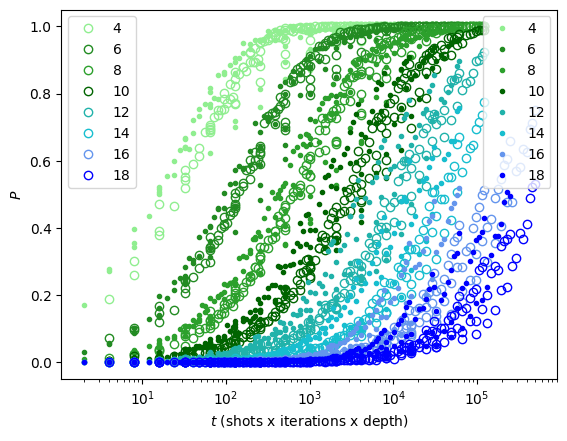

In [129]:
colors = ['lightgreen','forestgreen','tab:green','darkgreen', 'lightseagreen', 'tab:cyan','cornflowerblue' , 'blue', 'navy']
plots1 = []
plots2 = []

for i, (p,t) in enumerate(zip(psucc_1, ts_1)):
    if 4+i*2 > 18:
        continue
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, p=1, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots_1[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs_1[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in success probability for N={4+i*2}")
    # plot for each dimension
    p_t_1 = np.vstack((t, p))
    p_t_1 = p_t_1[:, np.argsort(p_t_1[0, :])]
    plot1, = plt.plot(p_t_1[0], p_t_1[1], ".", label=f"{4+i*2}", color=colors[i])
    plots1.append(plot1)

    try:
        last_zero = np.argwhere(np.isclose(psucc_2[i], 0.))
        print(f"N={4+i*2}, p=2, t={np.asarray(ts_2[i])[np.asarray(psucc_2[i])==0.].max()}, shots={np.asarray(shots_2[i])[np.asarray(psucc_2[i])==0.].max()}, nfev={np.asarray(nfevs_2[i])[np.asarray(psucc_2[i])==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t_2 = np.vstack((ts_2[i], psucc_2[i]))
    p_t_2 = p_t_2[:, np.argsort(p_t_2[0, :])]
    plot2, = plt.plot(p_t_2[0]*2, p_t_2[1], "o", label=f"{4+i*2}", color=colors[i], fillstyle='none')
    plots2.append(plot2)

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$P$")

# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='upper right')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left')

    #plt.savefig("p_t_n4-18.png")

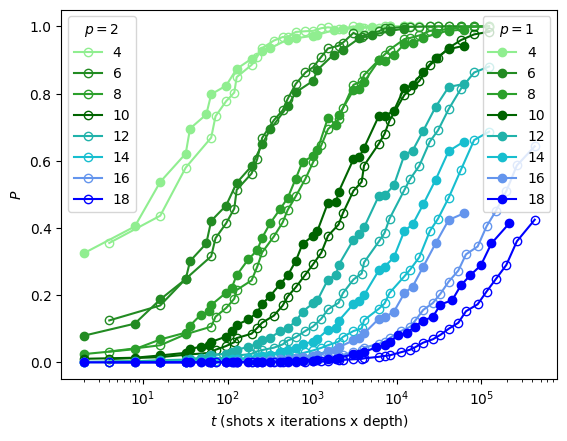

In [130]:
colors = ['lightgreen','forestgreen','tab:green','darkgreen', 'lightseagreen', 'tab:cyan','cornflowerblue' , 'blue', 'navy']
plots1 = []
plots2 = []

for i, (p,t) in enumerate(zip(psucc_1, ts_1)):
    if 4+i*2 > 18:
        continue
    p_t1 = np.vstack((t, p))
    p_t1 = p_t1[:, np.argsort(p_t1[0, :])]
    len_window = 12
    #p_t1[1] = np.convolve(p_t1[1], np.ones(len_window) / len_window, mode='same')
    p_t1[1] = running_mean(p_t1[1], len_window)
    plot1, = plt.plot(p_t1[0][::5], p_t1[1][::5], "o-", label=f"{4+i*2}", color=colors[i])
    plots1.append(plot1)

    p_t2 = np.vstack((ts_2[i], psucc_2[i]))
    p_t2 = p_t2[:, np.argsort(p_t2[0, :])]
    p_t2[1] = running_mean(p_t2[1], len_window)
    plot2, = plt.plot(p_t2[0][::5]*2, p_t2[1][::5], "o-", label=f"{4+i*2}", fillstyle='none', color=colors[i])
    plots2.append(plot2)

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$P$")

# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='upper right', title=r'$p=1$')
# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left', title=r'$p=2$')

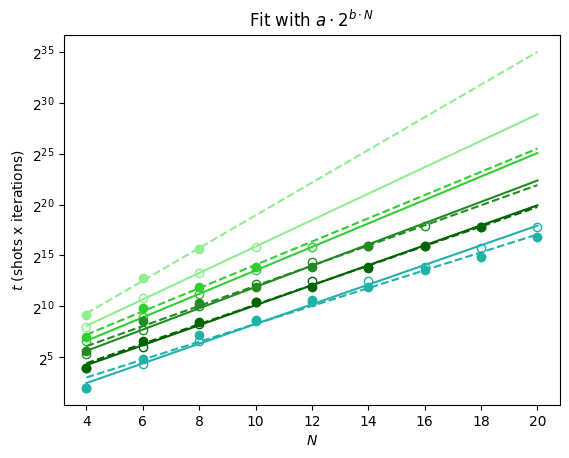

In [136]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x
    
pt_all = []
for i, (p,t) in enumerate(zip(psucc_1, ts_1)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)
pt_all_2 = []
for i, (p,t) in enumerate(zip(psucc_2, ts_2)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all_2.append(p_t)


colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
min_psucc_lst = [0.99, 0.9, 0.75, 0.5, 0.25]
min_qubits = 4 
max_qubits = 20 
for min_psucc, color in zip(min_psucc_lst, colors):
    step_size = []
    for i, pt in enumerate(pt_all):
        mask = pt[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size.append(pt[0][mask][0])

    x_axes = 4 + 2*np.arange(len(step_size))

    popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
    plt.plot(x_axes, step_size, "o", label=f"p={min_psucc}", color=color)
    plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "--", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)

    step_size_2 = []
    for i, pt_2 in enumerate(pt_all_2):
        mask = pt_2[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size_2.append(pt_2[0][mask][0])
    x_axes_2 = 4 + 2*np.arange(len(step_size_2))
    popt, _ = curve_fit(fun_lin, x_axes_2, np.log2(step_size_2))
    plt.plot(x_axes_2, step_size_2, "o", label=f"p={min_psucc}", color=color, fillstyle='none')
    plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")

#plt.legend(loc="best")
plt.title(r"Fit with $a \cdot 2^{b \cdot N}$")

plt.savefig("t_succ.png")


## Simulation with noise $p=2$



In [1]:
import numpy as np
from scipy.optimize import curve_fit
from math import ceil
from json import JSONEncoder
from matplotlib import pyplot as plt
from src.utils import collect_results, NumpyArrayEncoder
import json
import os

In [2]:
qubits = [4,6,8,10,12]
p = 2
# load exact simulations
psucc, ts, shots, nfevs = collect_results(qubits, p)

directory: results/N4/p2/
directory: results/N6/p2/
directory: results/N8/p2/
directory: results/N10/p2/
directory: results/N12/p2/


In [6]:
ts_noise = []
shots_noise = []
nfevs_noise = []
psucc_noise = []
for qubit in qubits:
    dir_path = f"results/N{qubit}/noise/"
    print(f"directory: {dir_path}")
    p = []
    t = []
    s = []
    it = []
    # for each number of qubits
    # we have several number of shots and iterations
    for filename in sorted(os.listdir(dir_path)):
        filename = dir_path + filename
        with open(filename, "r") as file:
            # print(filename)
            data = json.load(file)
        ever_found = []
        # for each shot and iteration param
        # we randomized the initial point
        # to estimate the right probability
        for run in data:
            ever_found.append(run["ever_found"])
        # compute p('found minimum')
        p.append(
            np.mean(np.asarray(ever_found, dtype=np.float128))
        )  # float128 to avoid to many zeros
        # maxiter*shots = actual number of iteration
        t.append(run["shots"] * run["nfev"])
        s.append(run["shots"])
        it.append(run["nfev"])
    # update list for each number of qubits
    ts_noise.append(t)
    psucc_noise.append(p)
    shots_noise.append(s)
    nfevs_noise.append(it)

directory: results/N4/noise/
directory: results/N6/noise/
directory: results/N8/noise/
directory: results/N10/noise/
directory: results/N12/noise/


No zeros in success probability for N=4
No zeros in success probability for N=6
No zeros in success probability for N=8
No zeros in success probability for N=10
No zeros in success probability for N=12
No zeros in succes probability for N=4
No zeros in succes probability for N=6
No zeros in succes probability for N=8
No zeros in succes probability for N=10
N=12, p=2, t=4, shots=2, nfev=2


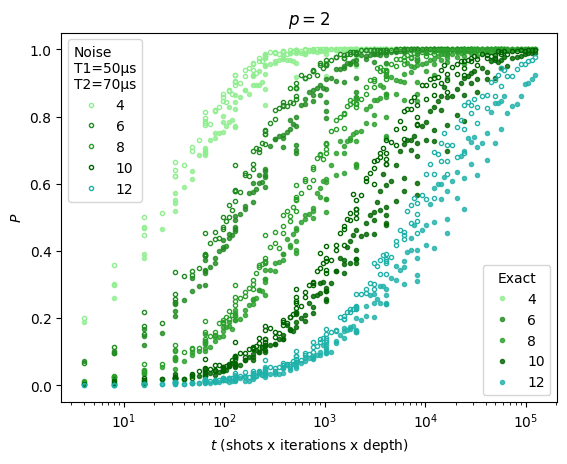

In [7]:
colors = ['lightgreen','forestgreen','tab:green','darkgreen', 'lightseagreen', 'tab:cyan','cornflowerblue' , 'blue', 'navy']
plots1 = []
plots2 = []

for i, (p,t) in enumerate(zip(psucc, ts)):
    if 4+i*2 > 18:
        continue
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, p=2, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in success probability for N={4+i*2}")
    # plot for each dimension
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    plot1, = plt.plot(p_t[0]*2, p_t[1], ".", label=f"{4+i*2}", color=colors[i], alpha=0.8)
    plots1.append(plot1)

for i, (p,t) in enumerate(zip(psucc_noise, ts_noise)):
    try:
        last_zero = np.argwhere(np.isclose(psucc_noise[i], 0.))
        print(f"N={4+i*2}, p=2, t={np.asarray(ts_noise[i])[np.asarray(psucc_noise[i])==0.].max()}, shots={np.asarray(shots_noise[i])[np.asarray(psucc_noise[i])==0.].max()}, nfev={np.asarray(nfevs_noise[i])[np.asarray(psucc_noise[i])==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t_noise = np.vstack((ts_noise[i], psucc_noise[i]))
    p_t_noise = p_t_noise[:, np.argsort(p_t_noise[0, :])]
    plot2, = plt.plot(p_t_noise[0]*2, p_t_noise[1], ".", label=f"{4+i*2}", color=colors[i], fillstyle='none')
    plots2.append(plot2)

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$P$")

# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='lower right', title="Exact")
#Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

plt.title(r"$p=2$")
#Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left', title=f"Noise\nT1=50\u03bcs\nT2=70\u03bcs")

plt.savefig("noise_exact.png")

No zeros in success probability for N=4
No zeros in success probability for N=6
No zeros in success probability for N=8
No zeros in success probability for N=10
No zeros in success probability for N=12
No zeros in succes probability for N=4
No zeros in succes probability for N=6
No zeros in succes probability for N=8
No zeros in succes probability for N=10
N=12, p=2, t=4, shots=2, nfev=2


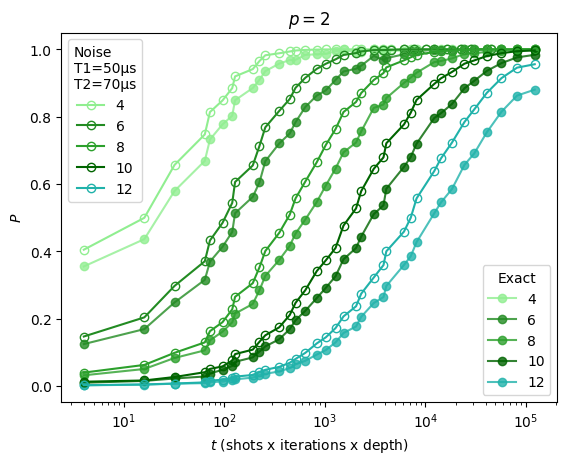

In [8]:
colors = ['lightgreen','forestgreen','tab:green','darkgreen', 'lightseagreen', 'tab:cyan','cornflowerblue' , 'blue', 'navy']
plots1 = []
plots2 = []

def running_mean(x, n):
    cumsum = np.cumsum(np.pad(x, int(ceil(n/2)), mode='reflect')) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

for i, (p,t) in enumerate(zip(psucc, ts)):
    if 4+i*2 > 18:
        continue
    try:
        last_zero = np.argwhere(np.isclose(p, 0.))
        print(f"N={4+i*2}, p=2, t={np.asarray(t)[np.asarray(p)==0.].max()}, shots={np.asarray(shots[i])[np.asarray(p)==0.].max()}, nfev={np.asarray(nfevs[i])[np.asarray(p)==0.].max()}")
    except ValueError:
        print(f"No zeros in success probability for N={4+i*2}")
    # plot for each dimension
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    len_window = 12
    p_t[1] = running_mean(p_t[1], len_window)
    plot1, = plt.plot(p_t[0][::5]*2, p_t[1][::5], "-o", label=f"{4+i*2}", color=colors[i], alpha=0.8)
    plots1.append(plot1)

for i, (p,t) in enumerate(zip(psucc_noise, ts_noise)):
    try:
        last_zero = np.argwhere(np.isclose(psucc_noise[i], 0.))
        print(f"N={4+i*2}, p=2, t={np.asarray(ts_noise[i])[np.asarray(psucc_noise[i])==0.].max()}, shots={np.asarray(shots_noise[i])[np.asarray(psucc_noise[i])==0.].max()}, nfev={np.asarray(nfevs_noise[i])[np.asarray(psucc_noise[i])==0.].max()}")
    except ValueError:
        print(f"No zeros in succes probability for N={4+i*2}")
    p_t_noise = np.vstack((ts_noise[i], psucc_noise[i]))
    p_t_noise = p_t_noise[:, np.argsort(p_t_noise[0, :])]
    len_window = 12
    p_t_noise[1] = running_mean(p_t_noise[1], len_window)
    plot2, = plt.plot(p_t_noise[0][::5]*2, p_t_noise[1][::5], "o-", label=f"{4+i*2}", color=colors[i], fillstyle='none')
    plots2.append(plot2)

    plt.xscale('log')
    plt.xlabel(r"$t$ (shots x iterations x depth)")
    plt.ylabel(r"$P$")

# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='lower right', title="Exact")
#Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

plt.title(r"$p=2$")
#Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left', title=f"Noise\nT1=50\u03bcs\nT2=70\u03bcs")

plt.savefig("noise_exact_roll.png")

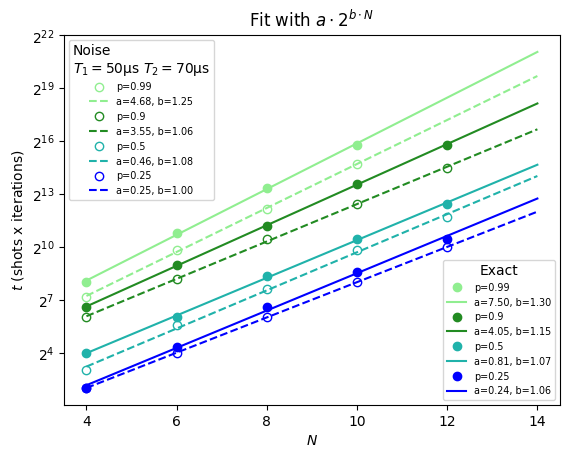

In [18]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x
    
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)
pt_all_2 = []
for i, (p,t) in enumerate(zip(psucc_noise, ts_noise)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all_2.append(p_t)


colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
min_psucc_lst = [0.99, 0.9, 0.5, 0.25]
min_qubits = 4 
max_qubits = 14
plots1 = [] 
plots2 = []
for min_psucc, color in zip(min_psucc_lst, colors[::2]):
    step_size = []
    for i, pt in enumerate(pt_all):
        mask = pt[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size.append(pt[0][mask][0])

    x_axes = 4 + 2*np.arange(len(step_size))

    popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
    plot1, = plt.plot(x_axes, step_size, "o", label=f"p={min_psucc}", color=color)
    plots1.append(plot1)
    plot1, = plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    plots1.append(plot1)

    step_size_2 = []
    for i, pt_2 in enumerate(pt_all_2):
        mask = pt_2[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size_2.append(pt_2[0][mask][0])
    x_axes_2 = 4 + 2*np.arange(len(step_size_2))
    popt, _ = curve_fit(fun_lin, x_axes_2, np.log2(step_size_2))
    plot2, = plt.plot(x_axes_2, step_size_2, "o", label=f"p={min_psucc}", color=color, fillstyle='none')
    plots2.append(plot2)
    plot2, = plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "--", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    plots2.append(plot2)

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")


# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='lower right', title="Exact", fontsize="x-small")
#Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

plt.title(r"$p=2$")
#Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left', title="Noise\n" + r"$T_1=50$" + f"\u03bcs" r" $T_2=70$" + f"\u03bcs", fontsize="x-small")

plt.title(r"Fit with $a \cdot 2^{b \cdot N}$")

plt.savefig("t_scale.png")

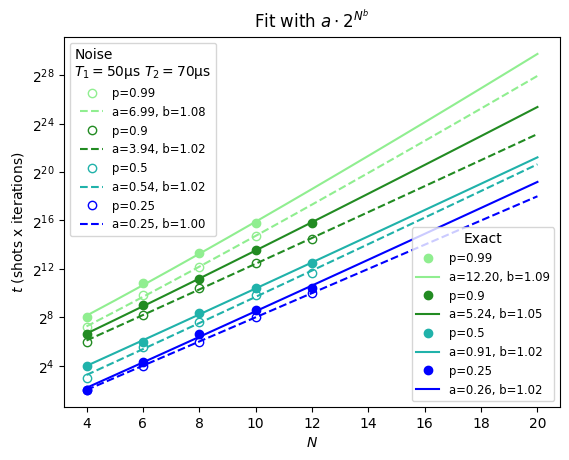

In [16]:
def fun_exp(x, a, b):
    return a*2**(x**b)

def fun_lin(x, a, b):
    return a + x**b
    
pt_all = []
for i, (p,t) in enumerate(zip(psucc, ts)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all.append(p_t)
pt_all_2 = []
for i, (p,t) in enumerate(zip(psucc_noise, ts_noise)):
    p_t = np.vstack((t, p))
    p_t = p_t[:, np.argsort(p_t[0, :])]
    pt_all_2.append(p_t)


colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
min_psucc_lst = [0.99, 0.9, 0.5, 0.25]
min_qubits = 4 
max_qubits = 20
plots1 = [] 
plots2 = []
for min_psucc, color in zip(min_psucc_lst, colors[::2]):
    step_size = []
    for i, pt in enumerate(pt_all):
        mask = pt[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size.append(pt[0][mask][0])

    x_axes = 4 + 2*np.arange(len(step_size))

    popt, _ = curve_fit(fun_lin, x_axes, np.log2(step_size))
    plot1, = plt.plot(x_axes, step_size, "o", label=f"p={min_psucc}", color=color)
    plots1.append(plot1)
    plot1, = plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    plots1.append(plot1)

    step_size_2 = []
    for i, pt_2 in enumerate(pt_all_2):
        mask = pt_2[1] >= min_psucc
        # check if the p is not reached
        if mask.sum() == 0:
            continue
        step_size_2.append(pt_2[0][mask][0])
    x_axes_2 = 4 + 2*np.arange(len(step_size_2))
    popt, _ = curve_fit(fun_lin, x_axes_2, np.log2(step_size_2))
    plot2, = plt.plot(x_axes_2, step_size_2, "o", label=f"p={min_psucc}", color=color, fillstyle='none')
    plots2.append(plot2)
    plot2, = plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 2**popt[0], popt[1]), "--", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    plots2.append(plot2)

plt.yscale('log', base=2)
plt.ylabel(r"$t$ (shots x iterations)")
plt.xlabel(r"$N$")


# Create a legend for the first line.
first_legend = plt.legend(handles=plots1, loc='lower right', title="Exact", fontsize="small")
#Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

plt.title(r"$p=2$")
#Create another legend for the second line.
plt.legend(handles=plots2, loc='upper left', title="Noise\n" + r"$T_1=50$" + f"\u03bcs" r" $T_2=70$" + f"\u03bcs", fontsize="small")

plt.title(r"Fit with $a \cdot 2^{N^b}$")

plt.savefig("t_scale_stretch.png")


## Test circuits with noise

Implement RealAmplitude ansatz and look for reliable noise setting. I load the noise from a qiskit class, from the actual real divece and I compare them with the exact simulation.

In [27]:
from math import pi
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import  RealAmplitudes
from qiskit.providers.fake_provider import FakeMumbaiV2, FakeVigoV2, FakeMumbai 
from qiskit.providers.aer import AerProvider, AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import IBMQ, transpile
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import thermal_relaxation_error, depolarizing_error


### Fake Device

Loads from qiskit class a shot of a real device.

In [28]:
# Mumbai has 27 qubots and quantum volume 128
device_backend = FakeMumbai()
noise_model = NoiseModel.from_backend(device_backend)
sim_fakenoise = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
            noise_model = noise_model, 
        )


### Custom noise

Implement custom noise in two different ways, setting damping time $T_1$ and dephasing time $T_2$ or depolarizing error $p_1$.

In [5]:
# T1 and T2 values for all qubits
# T1s = np.random.normal(50e3, 10e3) # Sampled from normal distribution mean 50 microsec
# T2s = np.random.normal(70e3, 10e3)  # Sampled from normal distribution mean 50 microsec

t1 = 50e3
t2 = 70e3

# Truncate random T2s <= T1s
#T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(20)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond


# QuantumError objects
errors_reset = thermal_relaxation_error(t1, t2, time_reset)
errors_measure = thermal_relaxation_error(t1, t2, time_measure)
errors_u1  = thermal_relaxation_error(t1, t2, time_u1)
errors_u2  = thermal_relaxation_error(t1, t2, time_u2)
errors_u3  = thermal_relaxation_error(t1, t2, time_u3)
errors_cx = thermal_relaxation_error(t1, t2, time_cx).expand(thermal_relaxation_error(t1, t2, time_cx))
# Add errors to noise model
noise_thermal = NoiseModel()
noise_thermal.add_all_qubit_quantum_error(errors_reset, "reset")
noise_thermal.add_all_qubit_quantum_error(errors_measure, "measure")
noise_thermal.add_all_qubit_quantum_error(errors_u1, "u1")
noise_thermal.add_all_qubit_quantum_error(errors_u2, "u2")
noise_thermal.add_all_qubit_quantum_error(errors_u3, "u3")

noise_thermal.add_all_qubit_quantum_error(errors_cx, "cx")


sim_customnoise = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
            noise_model=noise_thermal, 
        )

In [51]:
# depolarizing error

prob_1 = 1e-2 / 10. #1e-3 -> 1e-4 (best scenario)
prob_2 = prob_1 * 10. ##1e-2 -> 1e-3 (best) 
error_1 = depolarizing_error(prob_1, 1)
error_2 = depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3', 'h'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

sim_customnoise2 = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
            noise_model=noise_model, 
        )


### Real device noise 

Load the noise on the fly from current online devices, the maximum qubits number is thus limited to 7. 

In [8]:
# get a real backend from a real provider
provider = IBMQ.load_account()
# define noise from online ibm computer
backend = provider.get_backend('ibmq_manila')
noise_model = NoiseModel.from_backend(backend)
# generate a simulator that mimics the real quantum system with the latest calibration results
sim_realnoise = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
            noise_model = noise_model, 
        )

ibmqfactory.load_account:WARNING:2022-11-30 09:46:55,102: Credentials are already in use. The existing account in the session will be replaced.



### Exact simulation

We compare the noisy simulator with the exact one.

In [9]:
exact_sim = AerSimulator(
            method='statevector',
            max_parallel_threads=1,
        )

In [10]:
qubits = 4
circ_depth = 2
seed = 42


# create the circuit
# standard VQE ansatz
qc = RealAmplitudes(
    qubits,
    reps=circ_depth,
    insert_barriers=True,
    entanglement="circular",
)
# measure all qubits at the end of the circuit
qc.measure_all()

# define generator for initial point
rng = np.random.default_rng(seed=seed)
params =  np.ones(qc.num_parameters) * pi 
#params = np.random.uniform(-2 * pi, 2 * pi, qc.num_parameters)

qc = qc.assign_parameters(params)

print(qc)

        ┌──────────────────────────────────────────┐ ░ ┌─┐         
   q_0: ┤0                                         ├─░─┤M├─────────
        │                                          │ ░ └╥┘┌─┐      
   q_1: ┤1                                         ├─░──╫─┤M├──────
        │  RealAmplitudes(π,π,π,π,π,π,π,π,π,π,π,π) │ ░  ║ └╥┘┌─┐   
   q_2: ┤2                                         ├─░──╫──╫─┤M├───
        │                                          │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3                                         ├─░──╫──╫──╫─┤M├
        └──────────────────────────────────────────┘ ░  ║  ║  ║ └╥┘
meas_0: ════════════════════════════════════════════════╩══╬══╬══╬═
                                                           ║  ║  ║ 
meas_1: ═══════════════════════════════════════════════════╩══╬══╬═
                                                              ║  ║ 
meas_2: ══════════════════════════════════════════════════════╩══╬═
                                                

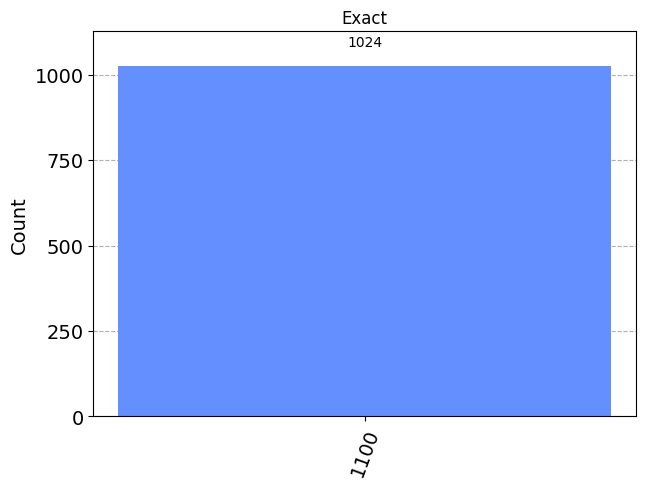

In [30]:
# Execute the circuit with fixed params
job = exact_sim.run(transpile(qc, exact_sim))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, title='Exact') #filename='exact_sim.png')

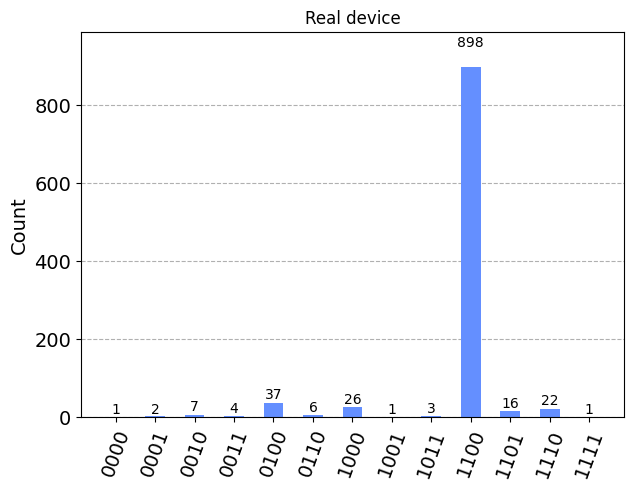

In [31]:
# Execute the circuit with fixed params
job = sim_realnoise.run(transpile(qc, sim_realnoise))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, title='Real device Manila')#filename='realnoise.png')

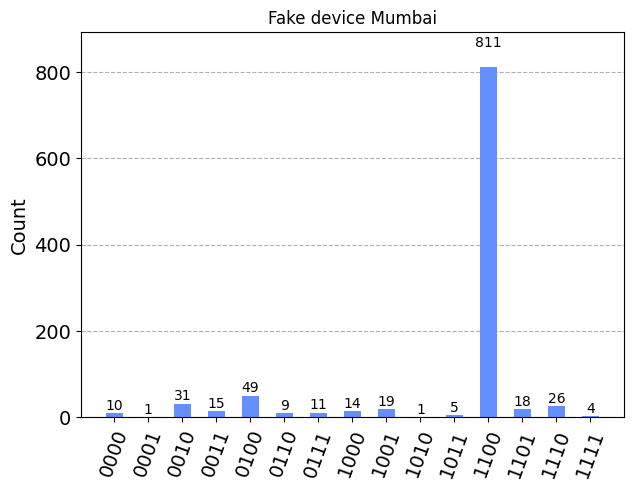

In [32]:
# Execute the circuit with fixed params
job = sim_fakenoise.run(transpile(qc, sim_fakenoise))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, title='Fake device Mumbai') #filename='fakenoise.png')

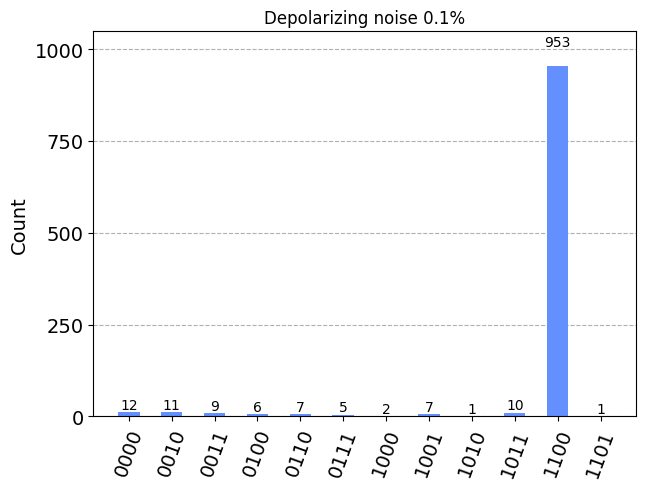

In [52]:
# Execute the circuit with fixed params
job = sim_customnoise2.run(transpile(qc, sim_customnoise2))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, title=f'Depolarizing noise {prob_1*1e2}%') #filename='customnoise2.png')

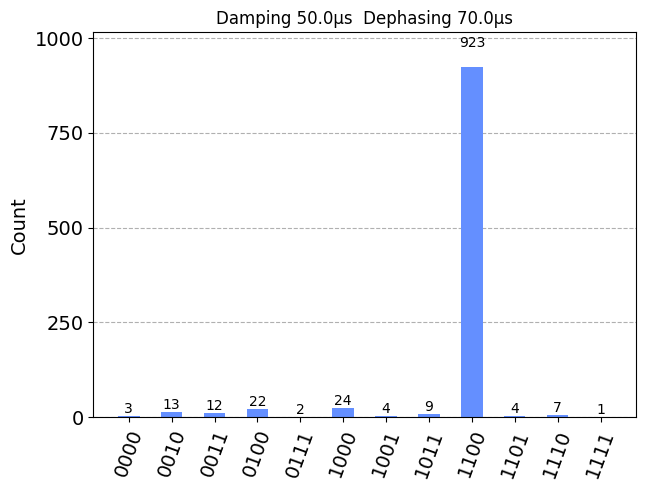

In [100]:
# Execute the circuit with fixed params
job = sim_customnoise.run(transpile(qc, sim_customnoise))
# Grab results from the job
result = job.result().get_counts()
# return counts
plot_histogram(result, title=f'Damping {t1//1e3}\u03bcs  Dephasing {t2//1e3}\u03bcs',)# filename='customnoise.png')


# TODO

- [x] nel plot dello scaling esponenziale della prob di successo inserire anche altre famiglie di p, i. e., p=[0.5, 0.6, 0.7, 0.8, 0.9]
- [x] studiare i rumori mediani degli ultimi device di IBM e capire quali sono i valori, a quel punto inserire il rumore nel codice o con una classe prefissata capendo come estrarre i valori del rumore oppure settandoli a mano
- [x] verificare la differenza tra i risultati del circuito rumoroso e quello del simulatore esatto per una taglia ragionevole e stampare i risultati per Guglielmo
- [ ] $p=2$ servono 10k per alcuni circuiti, da 14 in poi. VALUTARE BENE!!
- [x] d'ora in poi i tempi della cpu vanno normalizzati per numero di cpu e mediati per le iterazioni, l'obiettivo è avere un t/CPU medio
- [ ] provare modello frustrato $\pm1$
- [x] inizializzare con hadamart H gate su QAOA-inspired
